### Задача: классификация типов жуков по фотографии

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch import optim, cuda
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Optimizer, Adam, SGD
from torchvision import transforms, datasets
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.functional import softmax
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import ImageFile
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Разделение данных

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_dir = '../data/not_splitted'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
num_classes = len(dataset.classes)

print(f"size: {len(dataset)}\nnum classes: {num_classes}\nclasses: {dataset.classes}")

size: 6040
num classes: 4
classes: ['mustache', 'predator', 'rhinoceros', 'wievil']


In [3]:
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Пример

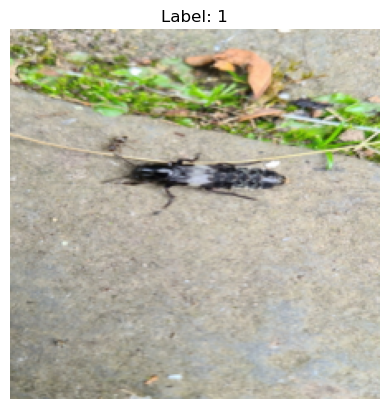

In [4]:
def denormalize_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

data_iter = iter(train_loader)
images, labels = next(data_iter)

image = images[0]
label = labels[0]

image = denormalize_image(image).permute(1, 2, 0).numpy()

plt.imshow(np.clip(image, 0, 1)) 
plt.title(f"Label: {label.item()}")
plt.axis("off")
plt.show()

### Функции для обучения и inference

In [5]:
def train(net: nn.Module,
          train_loader: DataLoader,
          optimizer : optim.Optimizer,
          num_epochs: int,
          device: str = 'cuda') -> tuple:
    
    cuda.empty_cache()
    loss_function = nn.CrossEntropyLoss()
    acc_history = []
    loss_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = loss_function(outputs, labels)
              
                loss.backward()

                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            acc = correct/total 
            acc_history.append(acc)
            avg_loss = running_loss / len(train_loader)
            loss_history.append(avg_loss)

        pbar.close()

    return acc_history, loss_history

In [6]:
def plot_loss_accuracy(histories: tuple):
    """
    Строит графики для loss и accuracy.
    """
    acc_history, loss_history = histories
    
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Loss', color='red', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, label='Accuracy', color='blue', marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def evaluate_acc(net, test_loader, device):

    total = 0
    correct = 0
    
    for batch_num, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    acc = correct/total
    return acc

### CNN

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(512*3*3, 128),
            nn.Dropout(0.1),
            nn.Tanh()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(128, num_classes),
            nn.Dropout(0.1),
            nn.Softmax(dim=1)
        )
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.layer6(x)
        x = self.layer7(x)
        return x

Epoch: 9, Batch: 150, Loss: 208.90, Acc: 0.25: 100%|██████████| 1510/1510 [06:02<00:00,  4.17it/s]


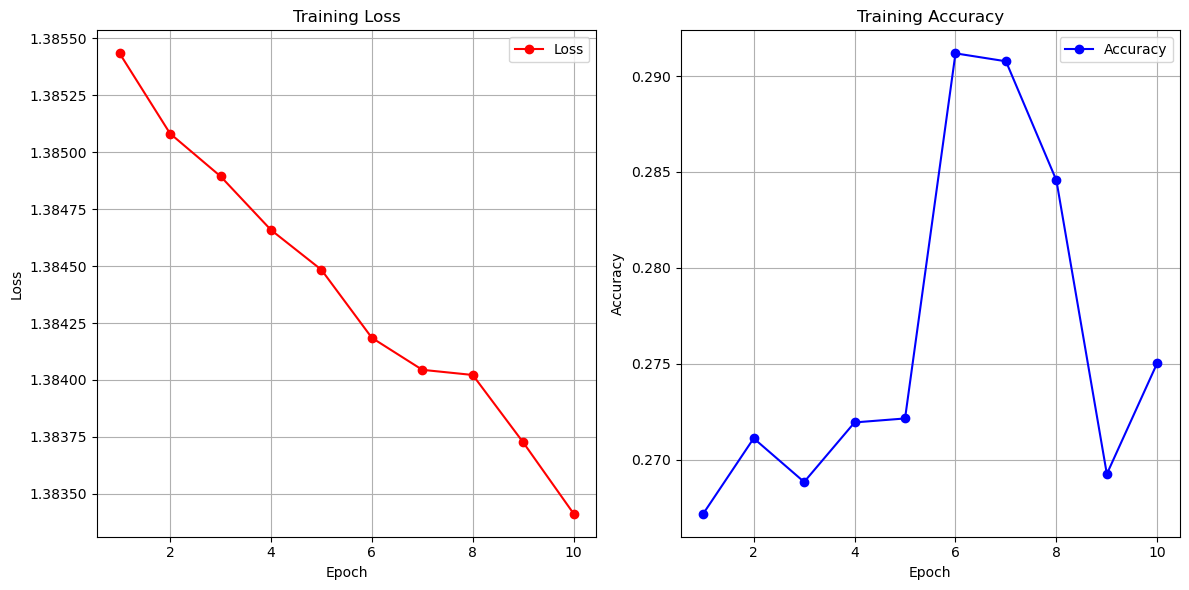

0.2731788079470199

In [9]:
NUM_EPOCHS = 10
LR = 0.01

net = CustomCNN(num_classes=num_classes).to(device)
optimizer = SGD(net.parameters(), lr=LR)

plot_loss_accuracy(train(net, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(net, test_loader, device)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Глобальный пул
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.4),  # Увеличенный Dropout
            nn.ReLU()
        )
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax()
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


  0%|          | 0/1510 [00:00<?, ?it/s]/home/victor/anaconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch: 9, Batch: 150, Loss: 194.01, Acc: 0.50: 100%|██████████| 1510/1510 [06:33<00:00,  3.84it/s]


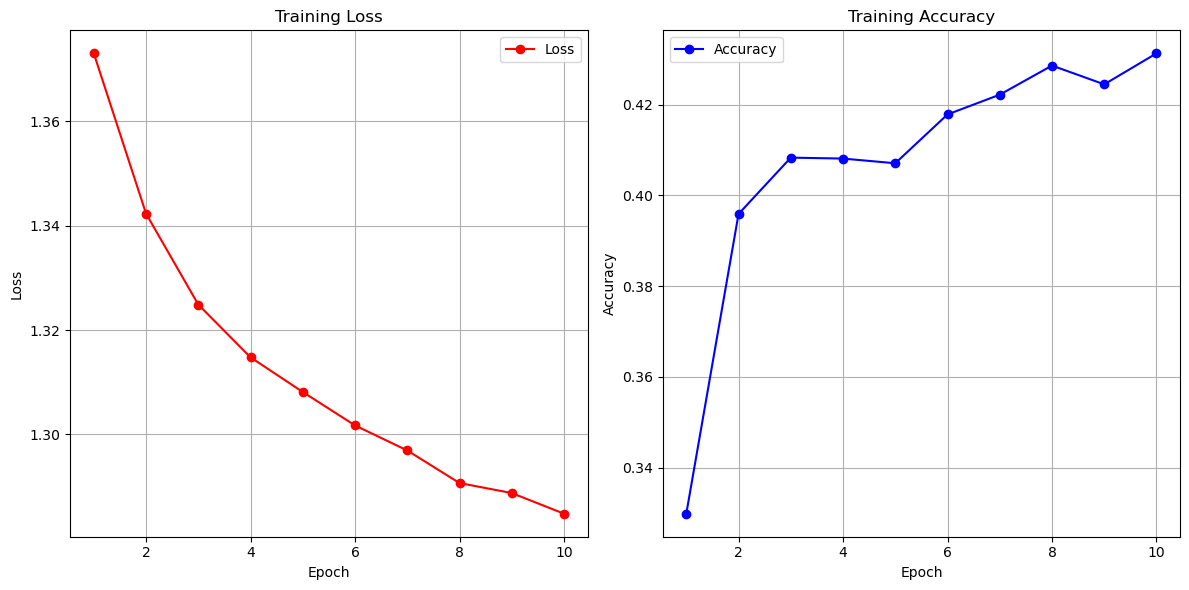

0.42135761589403975

In [11]:
NUM_EPOCHS = 10
LR = 0.01

net = ImprovedCNN(num_classes=num_classes).to(device)
optimizer = SGD(net.parameters(), lr=LR)

plot_loss_accuracy(train(net, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(net, test_loader, device)

### Трансферное обучение, Resnet18

In [12]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

for param in resnet.fc.parameters():
    param.requires_grad = True
    
resnet = resnet.to(device)

/home/victor/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 9, Batch: 150, Loss: 153.22, Acc: 0.84: 100%|██████████| 1510/1510 [05:17<00:00,  4.75it/s]


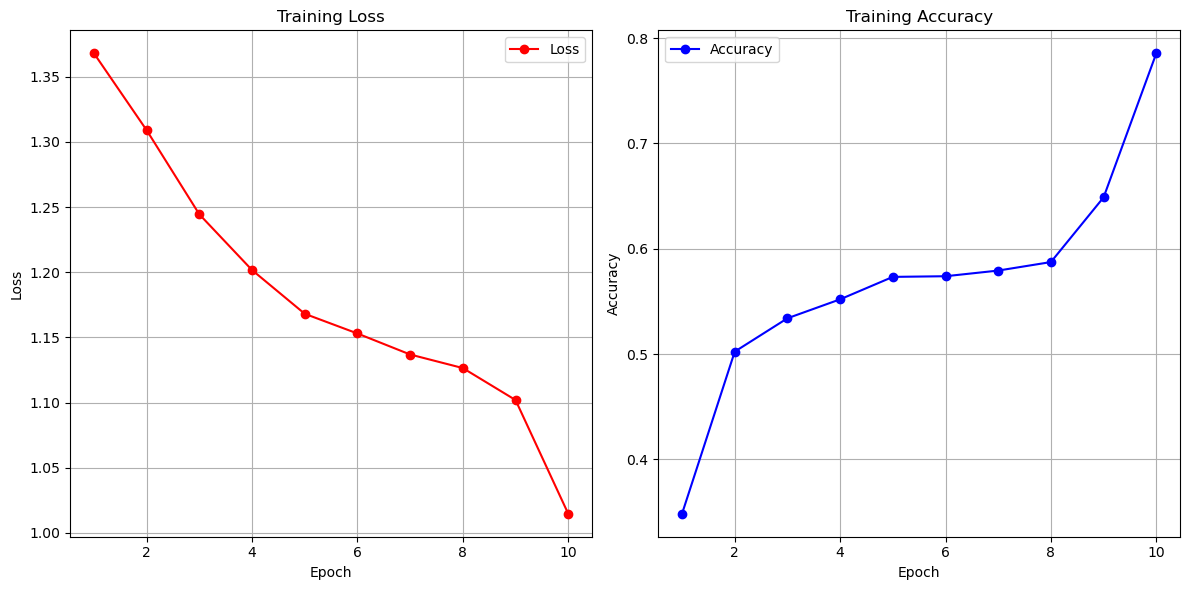

0.7706953642384106

In [13]:
NUM_EPOCHS = 10
LR = 0.01
optimizer = SGD(resnet.parameters(), lr=LR)

plot_loss_accuracy(train(resnet, train_loader, optimizer, num_epochs=NUM_EPOCHS))
evaluate_acc(resnet, test_loader, device)